In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/processed_data.csv', parse_dates=['date'])
print(df.head())

ModuleNotFoundError: No module named 'pandas'

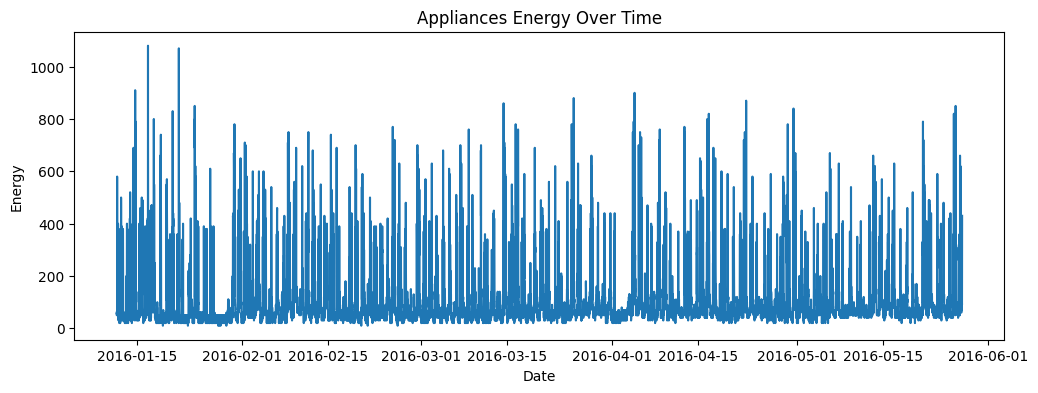

In [31]:

# Load data
df = pd.read_csv('../data/processed_data.csv', parse_dates=['date'])

# Plot Appliances energy over time
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['Appliances'], label='Energy (Wh)')
plt.title('Appliances Energy Over Time')
plt.xlabel('Date')
plt.ylabel('Energy')
plt.show()

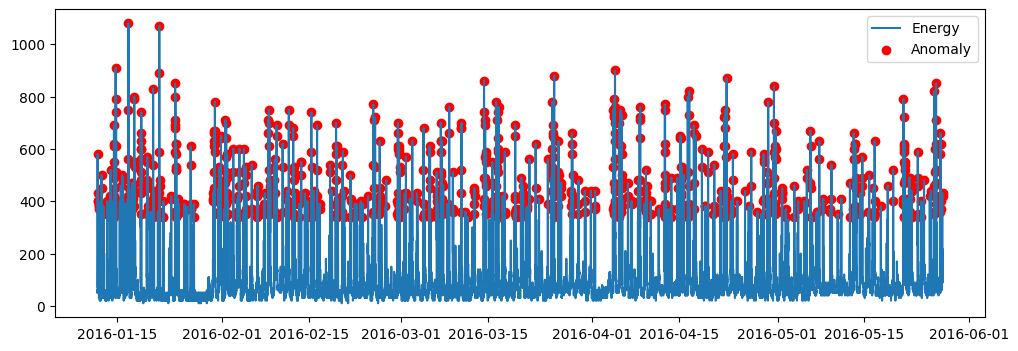

In [32]:
# Calculate Z-score
mean = df['Appliances'].mean()
std = df['Appliances'].std()
df['z_score'] = (df['Appliances'] - mean) / std

# Flag anomalies (e.g., Z-score > 3 or < -3)
threshold = df['z_score'].abs().quantile(0.95)  # Top 1% outliers
df['is_anomaly'] = df['z_score'].abs() > threshold

# df['is_anomaly'] = df['z_score'].abs() > 3

# Plot anomalies
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['Appliances'], label='Energy')
plt.scatter(df[df['is_anomaly']]['date'], df[df['is_anomaly']]['Appliances'], color='red', label='Anomaly')
plt.legend()
plt.show()

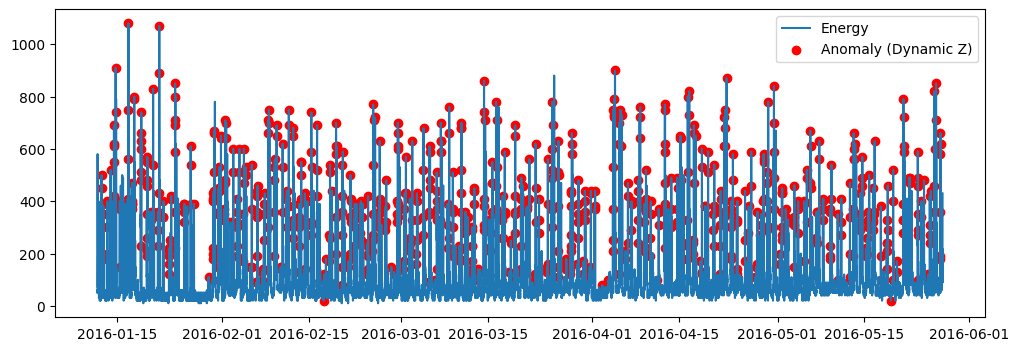

In [33]:
window = 12 * 6  # 24h * 6 samples/hour (10-min intervals)
df['rolling_mean'] = df['Appliances'].rolling(window).mean()
df['rolling_std'] = df['Appliances'].rolling(window).std()
df['dynamic_z'] = (df['Appliances'] - df['rolling_mean']) / df['rolling_std']
df['is_anomaly'] = df['dynamic_z'].abs() > 3  # Now context-aware!

plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['Appliances'], label='Energy')
plt.scatter(df[df['is_anomaly']]['date'], df[df['is_anomaly']]['Appliances'], color='red', label='Anomaly (Dynamic Z)')
plt.legend()
plt.show()

In [34]:
# Inspect flagged anomalies in the new results
anomalies = df[df['is_anomaly']][['date', 'Appliances', 'dynamic_z']]
print(anomalies.head())

                   date  Appliances  dynamic_z
103 2016-01-12 10:10:00         500   3.809523
104 2016-01-12 10:20:00         450   3.273612
227 2016-01-13 06:50:00         200   7.182966
236 2016-01-13 08:20:00         180   4.742774
237 2016-01-13 08:30:00         350   6.587931


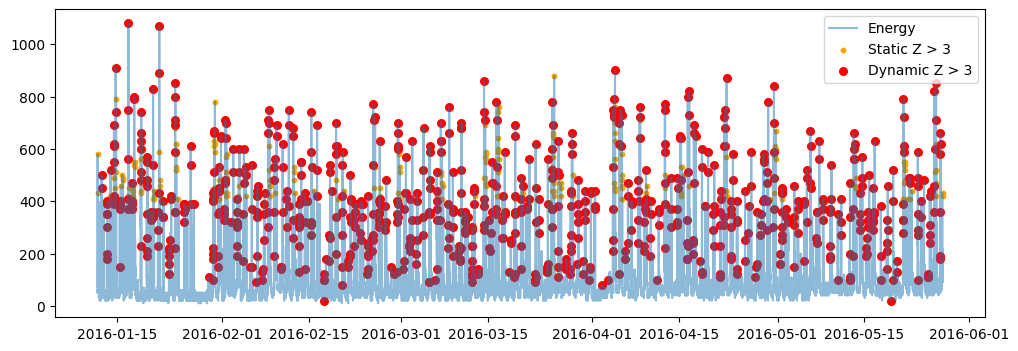

In [35]:
# Plot static vs. dynamic Z-score results
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['Appliances'], label='Energy', alpha=0.5)
# Old anomalies (static Z)
plt.scatter(df[df['z_score'].abs() > 3]['date'],
            df[df['z_score'].abs() > 3]['Appliances'],
            color='orange', label='Static Z > 3', s=10)
# New anomalies (dynamic Z)
plt.scatter(df[df['is_anomaly']]['date'],
            df[df['is_anomaly']]['Appliances'],
            color='red', label='Dynamic Z > 3', s=30)
plt.legend()
plt.show()

In [36]:
df[df['is_anomaly']].to_csv('detected_anomalies.csv')  # Save for analysis